In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
import itertools

In [2]:
df=pd.read_csv('product e.csv', parse_dates=['Month-Year'], index_col='Month-Year')

In [3]:
df.head(15)

,Product Name,Product Category,Month,Year,Sales,Market Size,Marketing Expense,Month No.
Month-Year,,,,,,,,
2019-01-01,Product E,Anti Biotic Respiratory,January,2019,57650,303130,2978499,1
2019-02-01,Product E,Anti Biotic Respiratory,February,2019,66035,347219,3411712,2
2019-03-01,Product E,Anti Biotic Respiratory,March,2019,88208,463807,4557285,3
2019-04-01,Product E,Anti Biotic Respiratory,April,2019,74712,392844,3860011,4
2019-05-01,Product E,Anti Biotic Respiratory,May,2019,61172,321649,3160464,5
2019-06-01,Product E,Anti Biotic Respiratory,June,2019,48721,256180,2517181,6
2019-07-01,Product E,Anti Biotic Respiratory,July,2019,51556,271087,2663652,7
2019-08-01,Product E,Anti Biotic Respiratory,August,2019,70726,371885,3654074,8
2019-09-01,Product E,Anti Biotic Respiratory,September,2019,70502,370707,3642501,9


In [4]:
sales_e= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [5]:
sales_e.shape

(60, 3)

In [6]:
sales_e.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2019-01-01 to 2023-12-01
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Sales              60 non-null     int64
 1   Market Size        60 non-null     int64
 2   Marketing Expense  60 non-null     int64
dtypes: int64(3)
memory usage: 1.9 KB


In [7]:
print('Total Sales:', sales_e['Sales'].sum())
print('Total Market Size:',sales_e['Market Size'].sum())
print('Total Marketing Expense:', sales_e['Marketing Expense'].sum())

Total Sales: 4925930
Total Market Size: 22616686
Total Marketing Expense: 97983937


Text(0.5, 1.0, 'Product E')

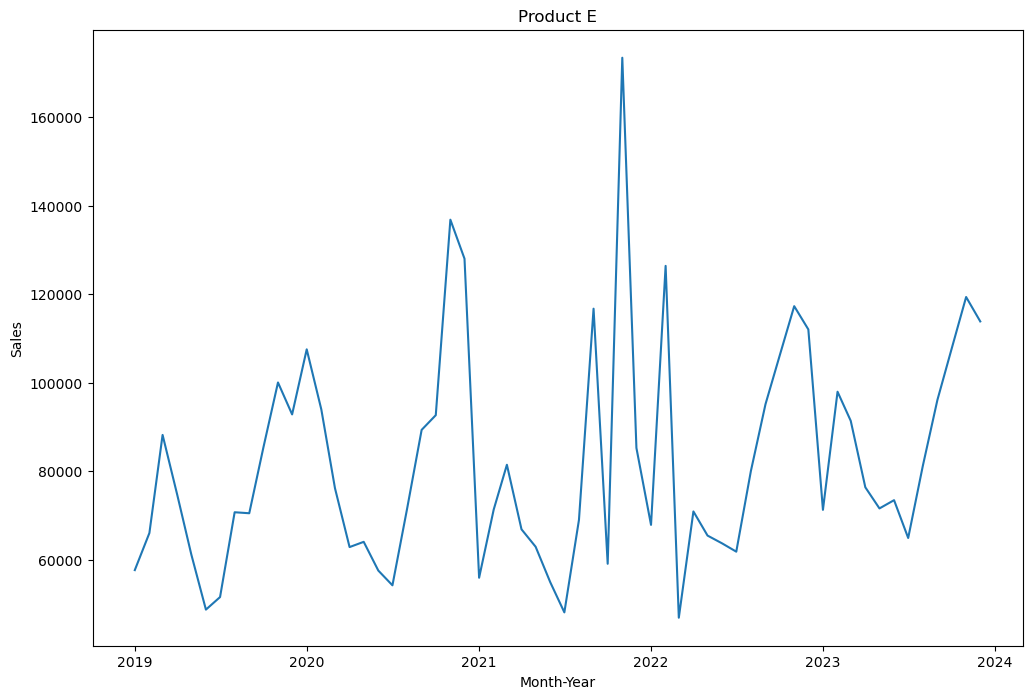

In [8]:
plt.figure(figsize=(12,8))
sns.lineplot(sales_e['Sales'])
plt.title('Product E')

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [11]:
adf_test(sales_e['Sales'])

ADF Statistics: -1.547517694729824
p- value: 0.5098879012430942
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [12]:
sales_e_diff= sales_e['Sales'].diff().dropna()

Text(0.5, 1.0, 'Product E - First Difference')

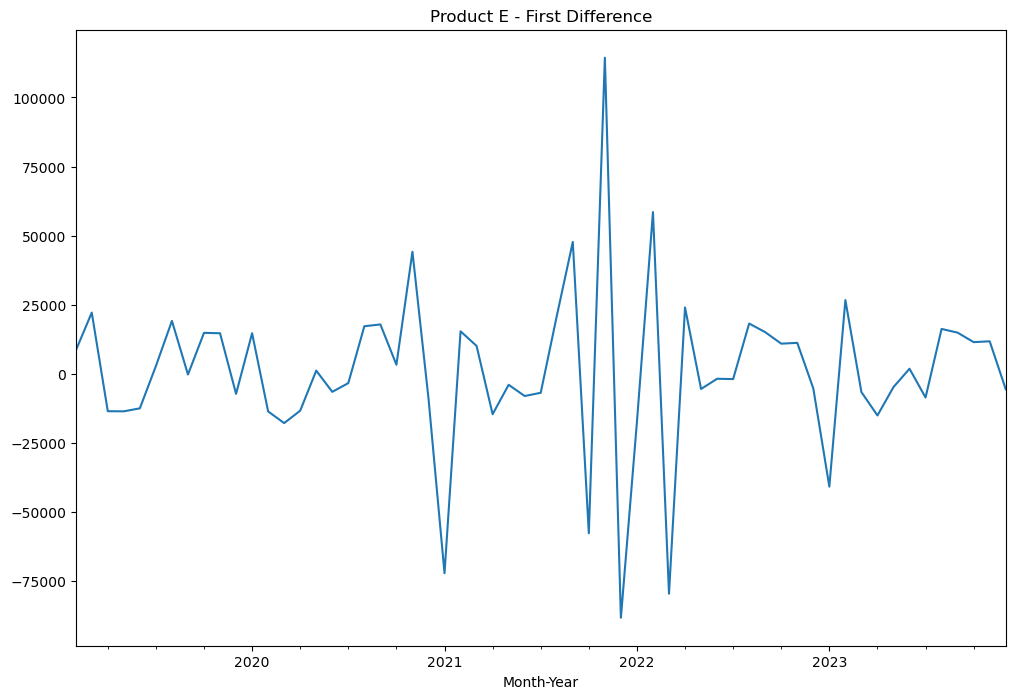

In [13]:
sales_e_diff.plot(figsize=(12,8))
plt.title('Product E - First Difference')

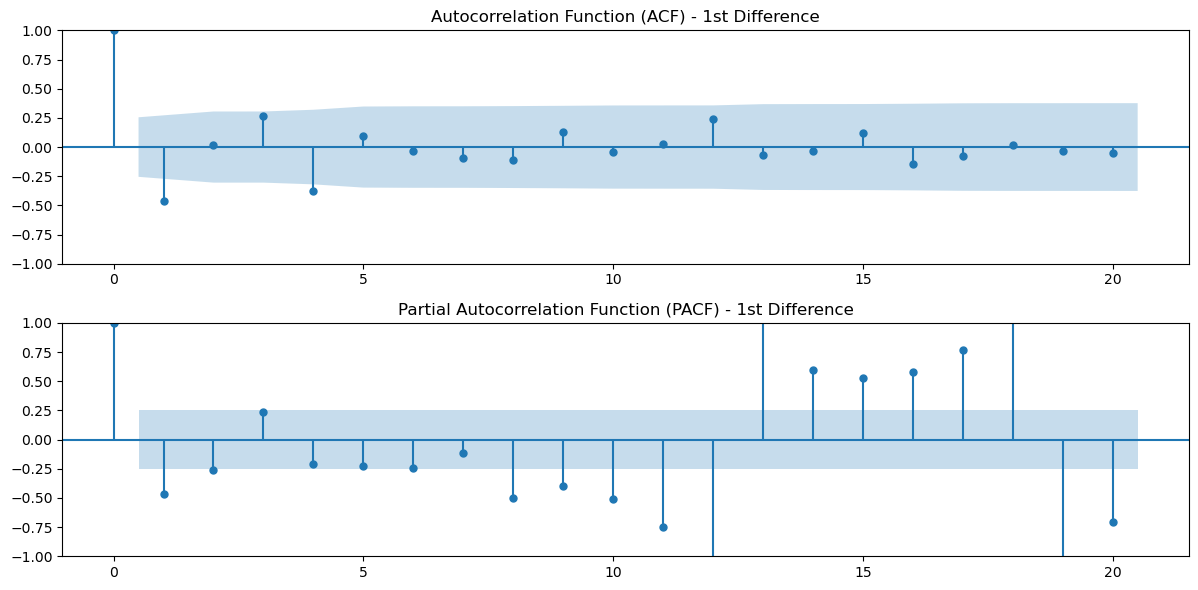

In [14]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_e_diff, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - 1st Difference')

plt.subplot(212)
plot_pacf(sales_e_diff, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - 1st Difference')

plt.tight_layout()
plt.show()

In [15]:
adf_test(sales_e_diff)

ADF Statistics: -6.125883961889508
p- value: 8.631648926998655e-08
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [16]:
train= sales_e[:48]
test=sales_e[48:]

In [17]:
len(train)

48

In [22]:
order=[]
for p in range(6):
    # Loop over MA order
    for q in range(3):
        # Fit model        
#       model= ARIMA(sales_b, order=(p,1,q))
        model_t = ARIMA(train['Sales'], order=(p,1,q), exog=train[['Market Size','Marketing Expense']])
        model_test=model_t.fit() 
        pred=model_test.predict(start=len(train), end=(len(sales_e)-1), exog=test[['Market Size','Marketing Expense']])
        mae = mean_absolute_error(test['Sales'], pred)
        mape = np.mean(np.abs((test['Sales'] - pred) / test)) * 100
        mse=mean_squared_error(test['Sales'], pred)
        rmse = np.sqrt(mean_squared_error(test['Sales'], pred))
        # Add order and scores to list        
        order.append((p, q, model_test.aic, model_test.bic,mae, mse, rmse))
#Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order, columns=['p','q', 'aic', 'bic', 'mae','mse', 'rmse'])

In [23]:
# Sort by AIC
print(order_df.sort_values('aic'))

    p  q          aic          bic           mae           mse          rmse
1   0  1  1090.074007  1097.474597   7417.251927  1.049455e+08  10244.292251
4   1  1  1090.181548  1099.432286   6812.259281  9.355334e+07   9672.297473
7   2  1  1090.330232  1101.431118   6711.893913  9.069474e+07   9523.378835
10  3  1  1091.484609  1104.435642   6732.044725  9.288364e+07   9637.615913
2   0  2  1092.219519  1101.470257   6920.005382  9.520522e+07   9757.315979
6   2  0  1092.558866  1101.809604  11373.269545  1.583361e+08  12583.166793
8   2  2  1092.751946  1105.702979   6912.039662  9.383947e+07   9687.077706
13  4  1  1093.182918  1107.984099   7812.280325  1.139243e+08  10673.530771
5   1  2  1093.483813  1104.584699   6857.973737  9.441903e+07   9716.945662
11  3  2  1093.947503  1108.748684   7053.028704  9.902663e+07   9951.212293
16  5  1  1094.431569  1111.082897   9232.223763  1.490526e+08  12208.711357
9   3  0  1094.464356  1105.565242  10492.771796  1.351586e+08  11625.774571

In [24]:
m_arima= ARIMA(train['Sales'], order=(0,1,1), exog=train[['Market Size','Marketing Expense']])
model_arima=m_arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -541.037
Date:                Thu, 09 May 2024   AIC                           1090.074
Time:                        17:29:52   BIC                           1097.475
Sample:                    01-01-2019   HQIC                          1092.859
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Market Size           0.1422      0.019      7.561      0.000       0.105       0.179
Marketing Expense    -0.0041      0.006     -0.711      0.477      -0.015       0.007
ma.L1                -0.

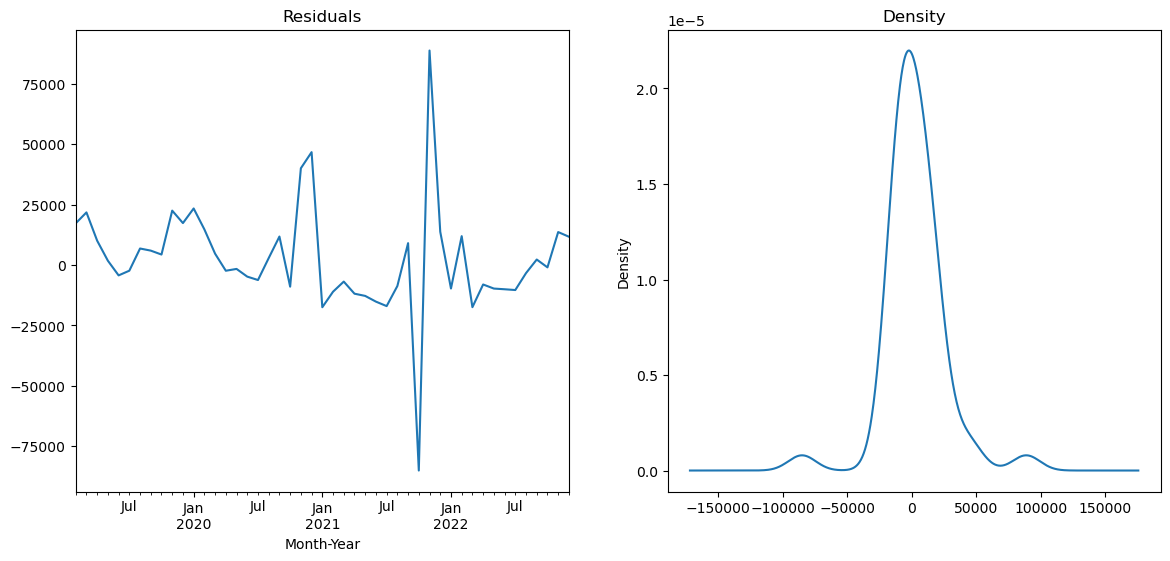

In [25]:
residuals= model_arima.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

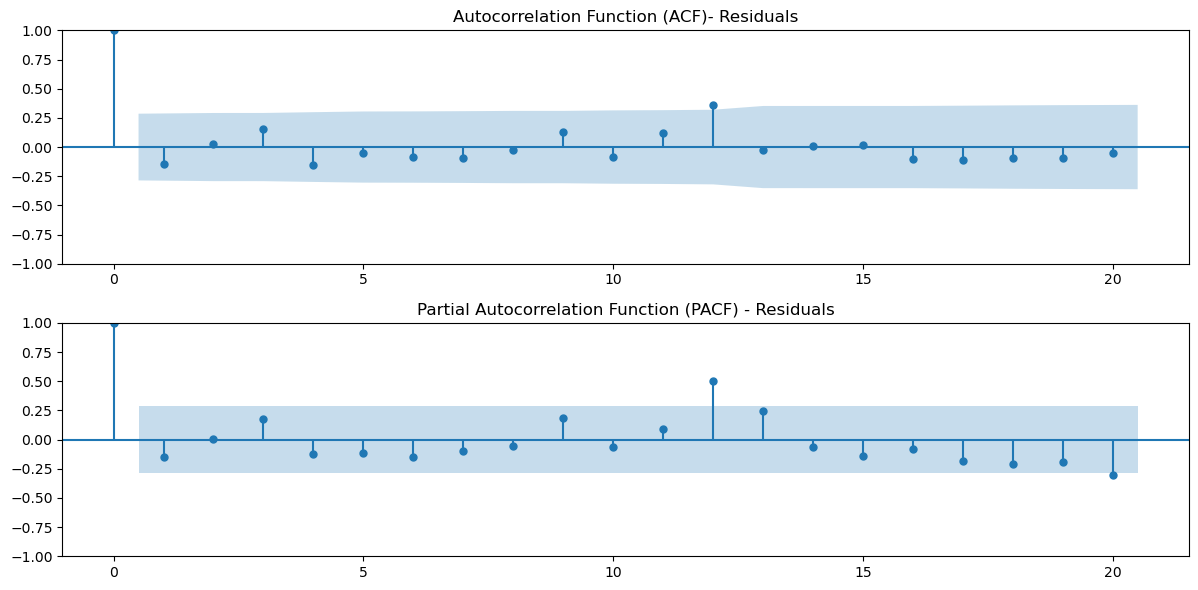

In [26]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)- Residuals')

plt.subplot(212)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Residuals')

plt.tight_layout()
plt.show()

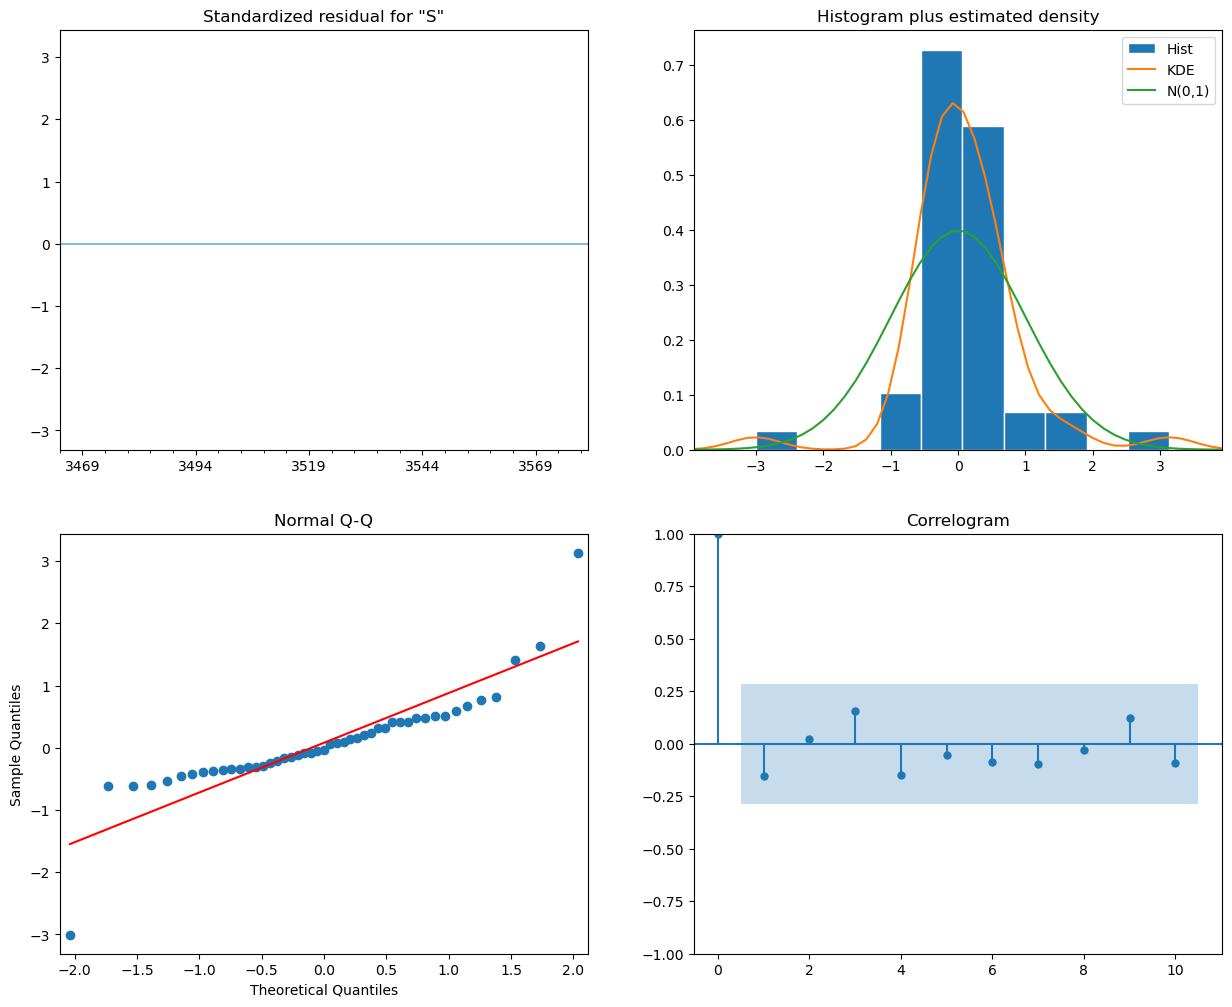

In [27]:
# Create the 4 diagostics plots
model_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [28]:
#pred_in_sample = model_arima.get_prediction(start=len(train), end=(len(sales_b)-1))
#sales_b['Forecast_ARIMA_p']=[None]*len(train) + list(pred)

In [29]:
#plt.figure(figsize=(12, 8))
#sns.lineplot(sales_b[['Sales','Forecast_ARIMA_p']])
#plt.title('Product B')
#plt.show()

In [30]:
pred=model_arima.predict(start=len(train), end=(len(sales_e)-1), exog=test[['Market Size','Marketing Expense']], dynamic = True)
sales_e['Forecast_ARIMAX']=[None]*len(train) + list(pred)
#sales_b.plot()

In [31]:
#pred=model_arima.forecast(steps= len(test))
#sales_b['Forecast_ARIMA']=[None]*len(train) + list(pred)
#sales_b.plot()

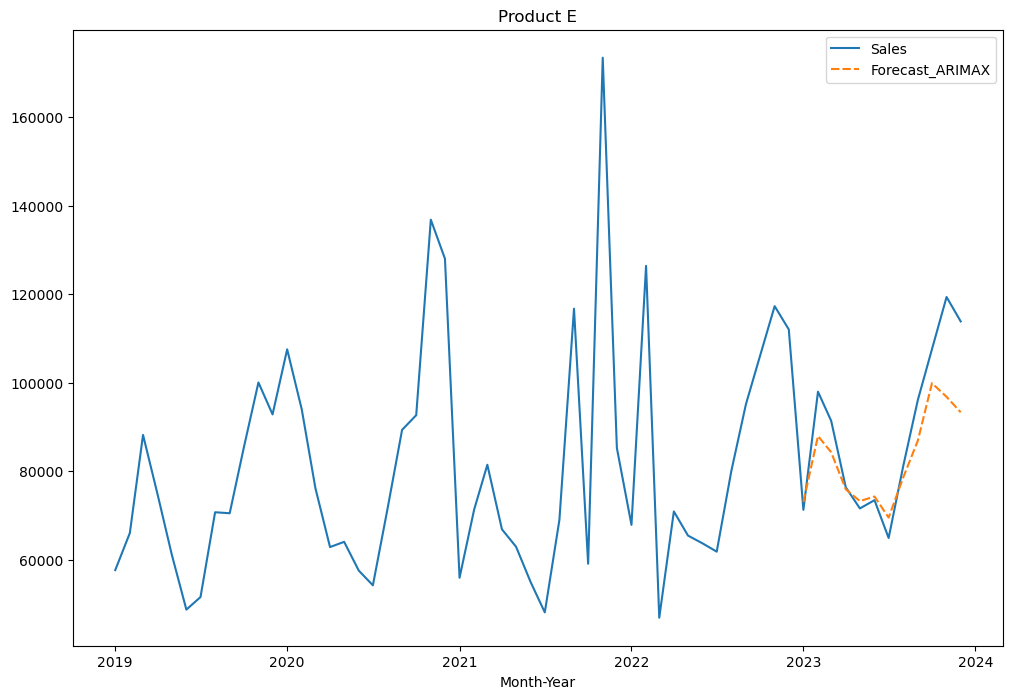

In [32]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_e[['Sales','Forecast_ARIMAX']])
plt.title('Product E')
plt.show()

In [33]:
mae_arimax= mean_absolute_error(test['Sales'],pred)
mse_arimax=mean_squared_error(test['Sales'], pred)
mape_arimax= mean_absolute_percentage_error(test['Sales'],pred)
rmse_arimax= np.sqrt(mean_squared_error(test['Sales'],pred))

print(f'MAE - ARIMAX: {mae_arimax}')
print(f'MAPE - ARIMAX: {mape_arimax}')
print(f'MSE - ARIMAX: {mse_arimax}')
print(f'RMSE - ARIMAX: {rmse_arimax}')

MAE - ARIMAX: 7417.251926606331
MAPE - ARIMAX: 0.07372521414923719
MSE - ARIMAX: 104945523.71402104
RMSE - ARIMAX: 10244.292250517898


# SARIMA

In [34]:
import statsmodels.api as sm

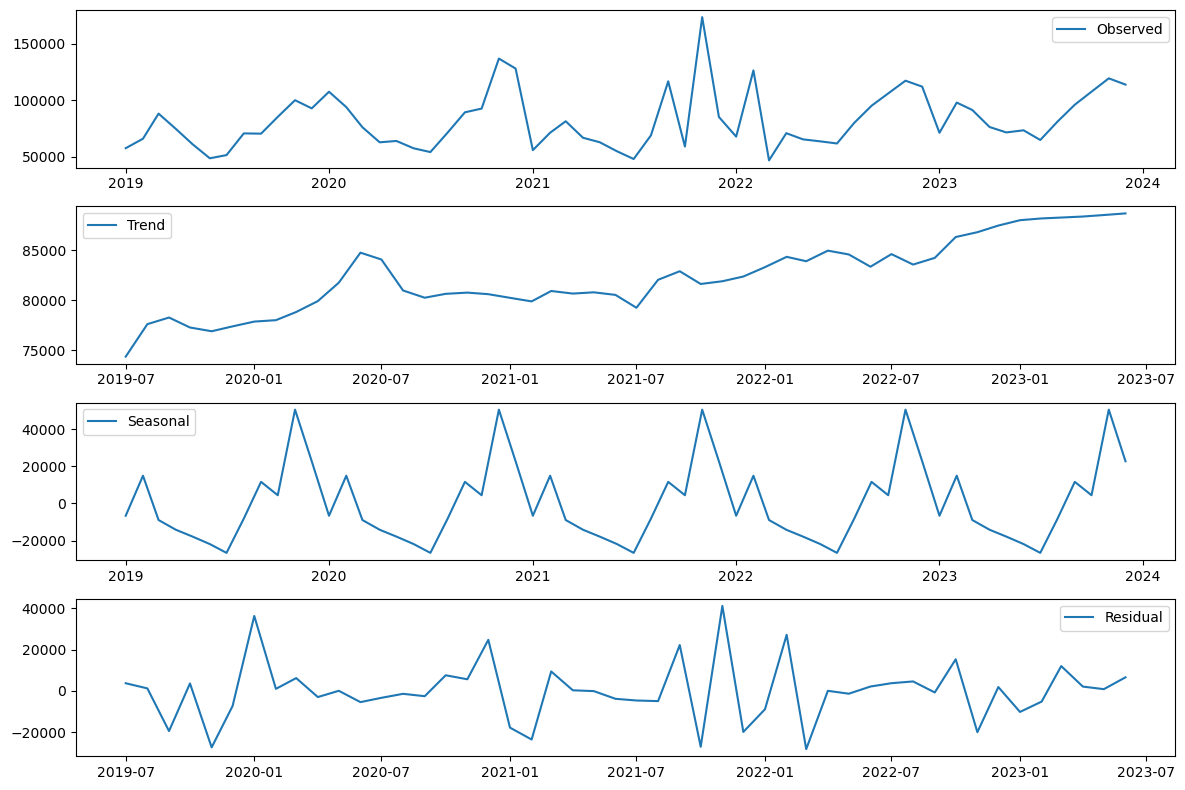

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_e['Sales'], model='additive', period=12)

# Plot the decomposition
#fig = decomposition.plot(figsize=(12,8))
#plt.show()
# Create a new figure with the specified size
plt.figure(figsize=(12, 8))

# Plot each component separately
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

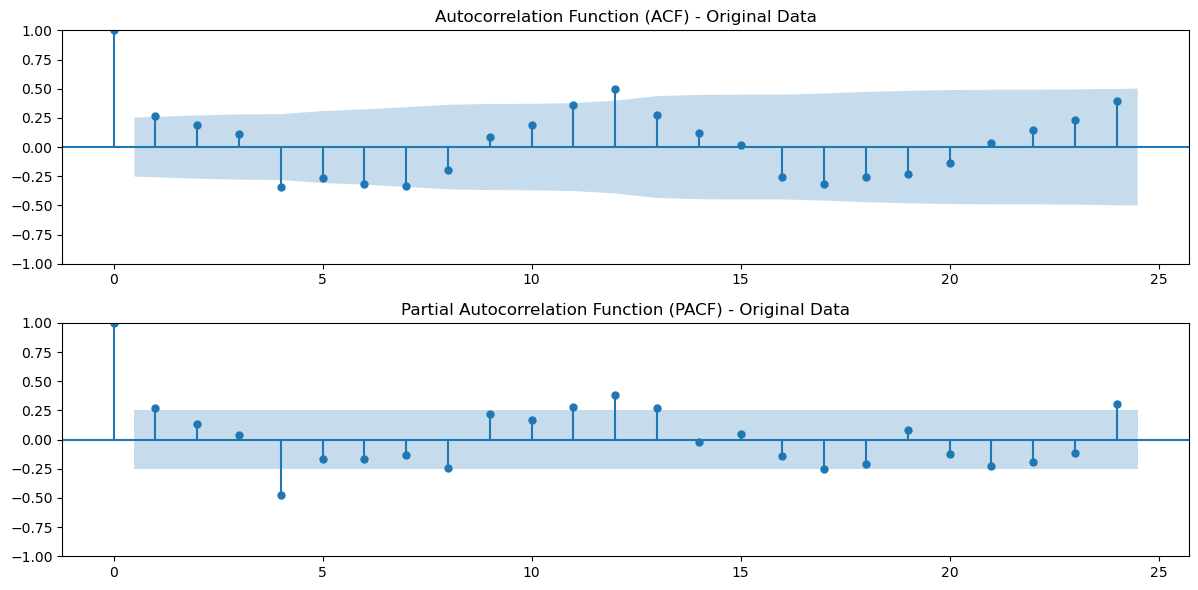

In [36]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_e['Sales'], lags=24, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Data')

plt.subplot(212)
plot_pacf(sales_e['Sales'], lags=24, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Data')

plt.tight_layout()
plt.show()

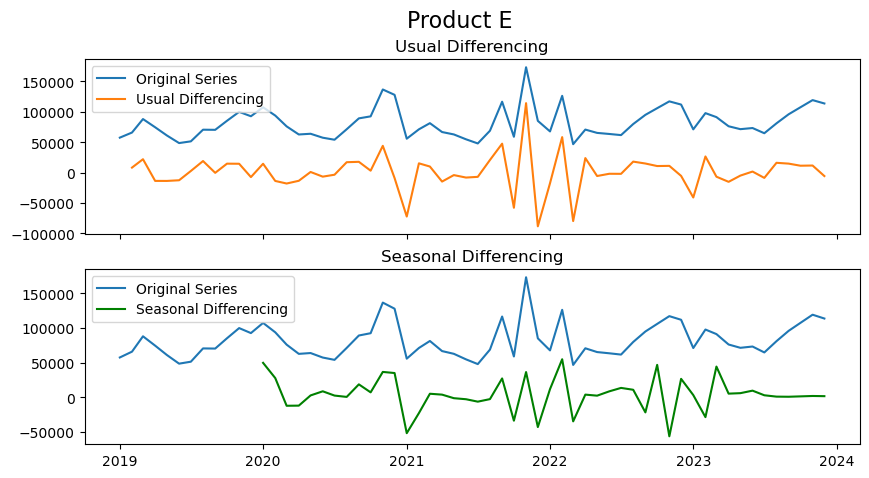

In [37]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(sales_e['Sales'], label='Original Series')
axes[0].plot(sales_e['Sales'].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(sales_e['Sales'], label='Original Series')
axes[1].plot(sales_e['Sales'].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Product E', fontsize=16)
plt.show()

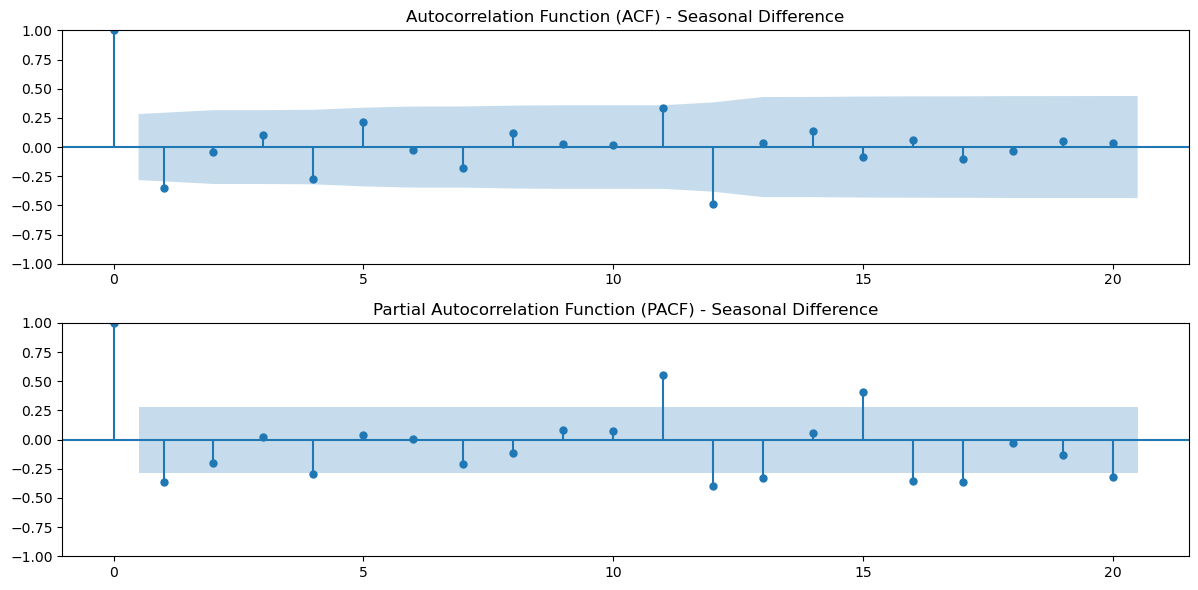

In [38]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_e['Sales'].diff(12).dropna(), lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Seasonal Difference')

plt.subplot(212)
plot_pacf(sales_e['Sales'].diff(12).dropna(), lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Seasonal Difference')

plt.tight_layout()
plt.show()

In [39]:
order_SARIMAX=[]
# Loop over P order
for P in range(6):
    # Loop over Q order
    for Q in range(3):
        # Fit model
        model_s = sm.tsa.statespace.SARIMAX(train['Sales'], order=(0, 1, 1), seasonal_order=(P, 1, Q, 12),exog=train[['Market Size','Marketing Expense']])
        model_test_s = model_s.fit() 
        pred = model_test_s.predict(start=48, end=59, dynamic=True, exog=test[['Market Size','Marketing Expense']])
        mae = mean_absolute_error(test['Sales'], pred)
        mse = mean_squared_error(test['Sales'], pred)
        # Add order and scores to list        
        order_SARIMAX.append((P, Q, model_test_s.aic, model_test_s.bic, mae, mse))

# Make DataFrame of model order and scores
order_SARIMAX_df = pd.DataFrame(order_SARIMAX, columns=['P', 'Q', 'aic', 'bic', 'mae', 'mse'])


In [40]:
# Sort by AIC
print(order_SARIMAX_df.sort_values('aic'))

    P  Q         aic         bic           mae           mse
1   0  1  822.284552  830.061292   5112.882877  7.279017e+07
9   3  0  824.199740  835.087177   6948.381754  5.789298e+07
2   0  2  824.275555  833.607643   4971.067070  6.454999e+07
4   1  1  824.283431  833.615520   5072.079553  6.423221e+07
3   1  0  824.616903  832.393643  22525.936809  7.456725e+08
6   2  0  825.821116  835.153204   9023.648890  1.865373e+08
7   2  1  826.088637  836.976073   6685.423840  5.365500e+07
12  4  0  826.200033  838.642817   6937.176514  5.811282e+07
10  3  1  826.202618  838.645402   7169.988594  5.963921e+07
5   1  2  826.284528  837.171965   5111.832230  7.219315e+07
8   2  2  828.187553  840.630337   8086.324811  1.601254e+08
13  4  1  828.199706  842.197839   6954.940099  5.801395e+07
15  5  0  828.200287  842.198420   6892.495863  5.756685e+07
11  3  2  828.202752  842.200884   6971.084943  5.908233e+07
0   0  0  830.171490  836.392882   8168.564602  1.054196e+08
16  5  1  830.199743  84

In [41]:
sarima=sm.tsa.statespace.SARIMAX(train['Sales'],order=(0, 1, 1),seasonal_order=(0,1,1,12),exog=train[['Market Size','Marketing Expense']])
sarima_model=sarima.fit()
print(sarima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -406.142
Date:                            Thu, 09 May 2024   AIC                            822.285
Time:                                    17:39:46   BIC                            830.061
Sample:                                01-01-2019   HQIC                           824.969
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Market Size           0.1291      0.038      3.439      0.001       0.056       0.203
Marketing Expe

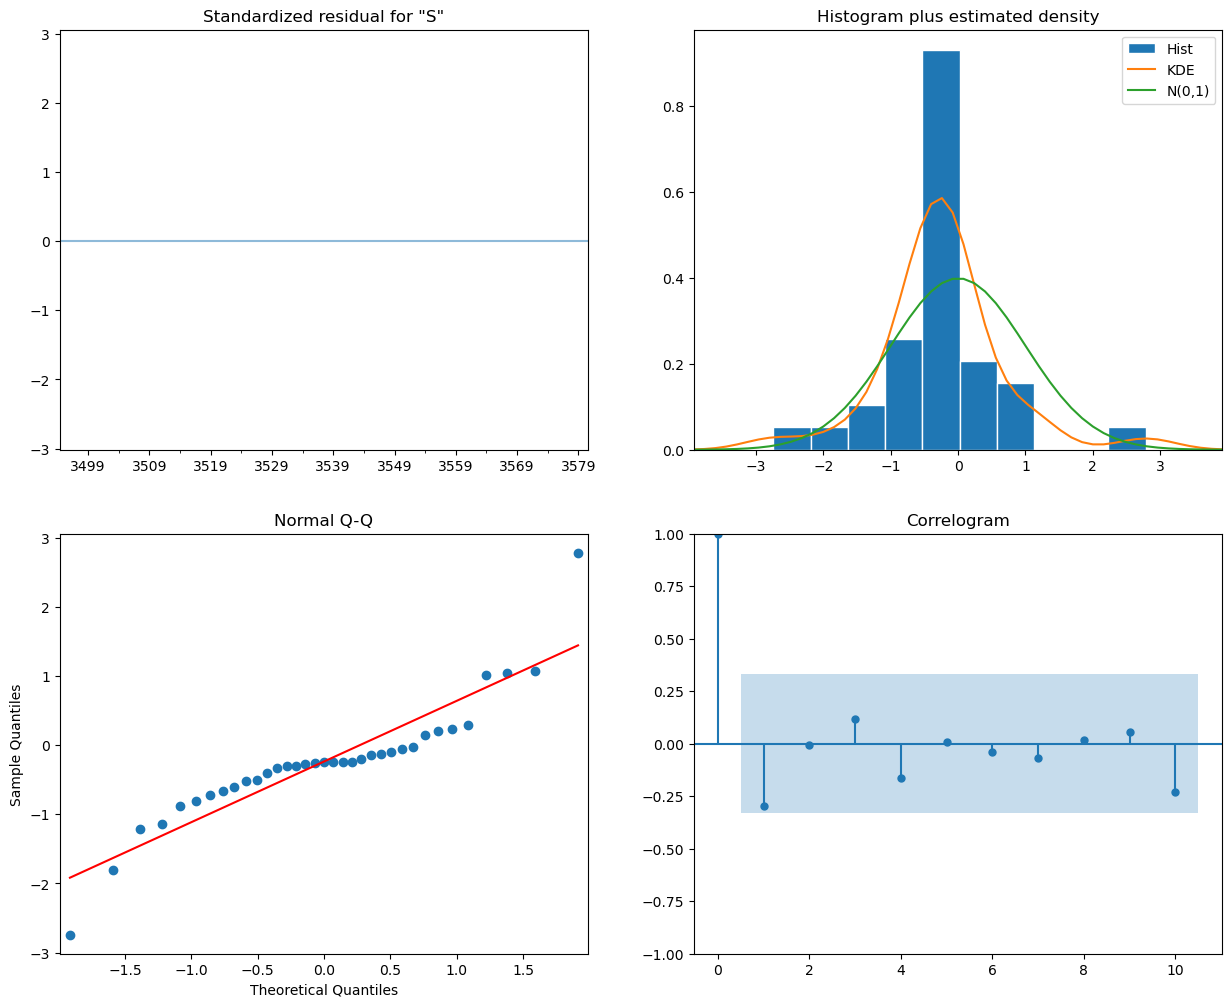

In [42]:
sarima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [43]:
forecast_test_sarima=sarima_model.predict(start=48, end=59, dynamic=True, exog=test[['Market Size','Marketing Expense']])

In [44]:
sales_e['Forecast_SARIMAX']=[None]*len(train)+ list(forecast_test_sarima)
#sales_b[['Sales','Forecast_SARIMA']].plot(figsize=(12,8))

Text(0.5, 1.0, 'Product E')

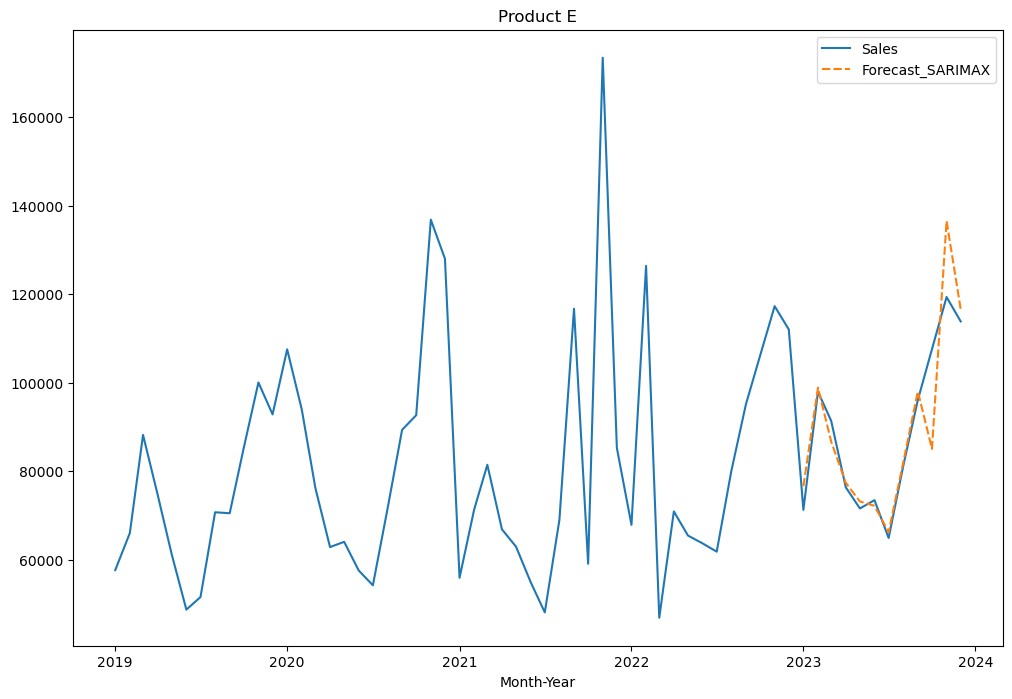

In [45]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_e[['Sales','Forecast_SARIMAX']])
plt.title('Product E')

In [46]:
mae_sarimax= mean_absolute_error(test['Sales'],forecast_test_sarima)
mape_sarimax= mean_absolute_percentage_error(test['Sales'],forecast_test_sarima)
mse_sarimax=mean_squared_error(test['Sales'], forecast_test_sarima)
rmse_sarimax= np.sqrt(mean_squared_error(test['Sales'],forecast_test_sarima))

print(f'MAE - SARIMAX: {round(mae_sarimax,3)}')
print(f'MAPE - SARIMAX: {round(mape_sarimax,3)}')
print(f'MSE - SARIMAX: {round(mse_sarimax,3)}')
print(f'RMSE - SARIMAX: {round(rmse_sarimax,3)}')

MAE - SARIMAX: 5112.883
MAPE - SARIMAX: 0.051
MSE - SARIMAX: 72790173.011
RMSE - SARIMAX: 8531.716


# AUTO-ARIMA

In [47]:
import pmdarima as pm

In [48]:
auto_arima= pm.auto_arima(train['Sales'], start_p=0, d=1, start_q=0, max_p=6,max_q=2,
                          start_P=0, D=1, start_Q=0, max_P=6 ,max_Q=3 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12, exogenous=train[['Market Size','Marketing Expense']])
auto_arima

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=851.050, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=842.630, Time=0.11 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=844.349, Time=0.17 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=846.106, Time=1.05 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=843.277, Time=0.07 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=844.594, Time=0.19 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=846.275, Time=0.52 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=848.049, Time=3.24 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=846.400, Time=0.25 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=846.589, Time=0.46 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=848.275, Time=0.63 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=850.010, Time=4.31 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=846.540, Time=1.57 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=848.229, Time=2.47 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=849.939, Time=3.77 sec
 ARIMA(0,1

ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [49]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -409.098
Date:                            Thu, 09 May 2024   AIC                            828.195
Time:                                    17:42:04   BIC                            835.972
Sample:                                01-01-2019   HQIC                           830.880
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4259      0.121    -11.814      0.000      -1.662      -1.189
ar.L2         -0.6564      0.166     -3.965      0.000      -0.981      -0.332
ma.L1          0.9807      0.322      3.050      0.002       0.350       1.611
ma.S.L12      -0.6929      0.374     -1.853      0.064      -1.426       0.040
sigma2      8.426e+08   4.31e-10   1.96e+18      0.000    8.43e+08    8.43e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):                 5.24
Prob(Q):                              0.51   Prob(JB):                         0.07
Heteroskedasticity (H):               0.34   Skew:                            -0.66
Prob(H) (two-sided):                  0.08   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.01e+34. Standard errors may be unstable.
"""

In [50]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -409.098
Date:                            Thu, 09 May 2024   AIC                            828.195
Time:                                    17:42:04   BIC                            835.972
Sample:                                01-01-2019   HQIC                           830.880
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4259      0.121    -11.814      0.000      -1.662      -1.189
ar.L2         -0.6564      0.166     -3.965      0.000      -0.981      -0.332
ma.L1          0.9807      0.322      3.050      0.002       0.350       1.611
ma.S.L12      -0.6929      0.374     -1.853      0.064      -1.426       0.040
sigma2      8.426e+08   4.31e-10   1.96e+18      0.000    8.43e+08    8.43e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):                 5.24
Prob(Q):                              0.51   Prob(JB):                         0.07
Heteroskedasticity (H):               0.34   Skew:                            -0.66
Prob(H) (two-sided):                  0.08   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.01e+34. Standard errors may be unstable.
"""

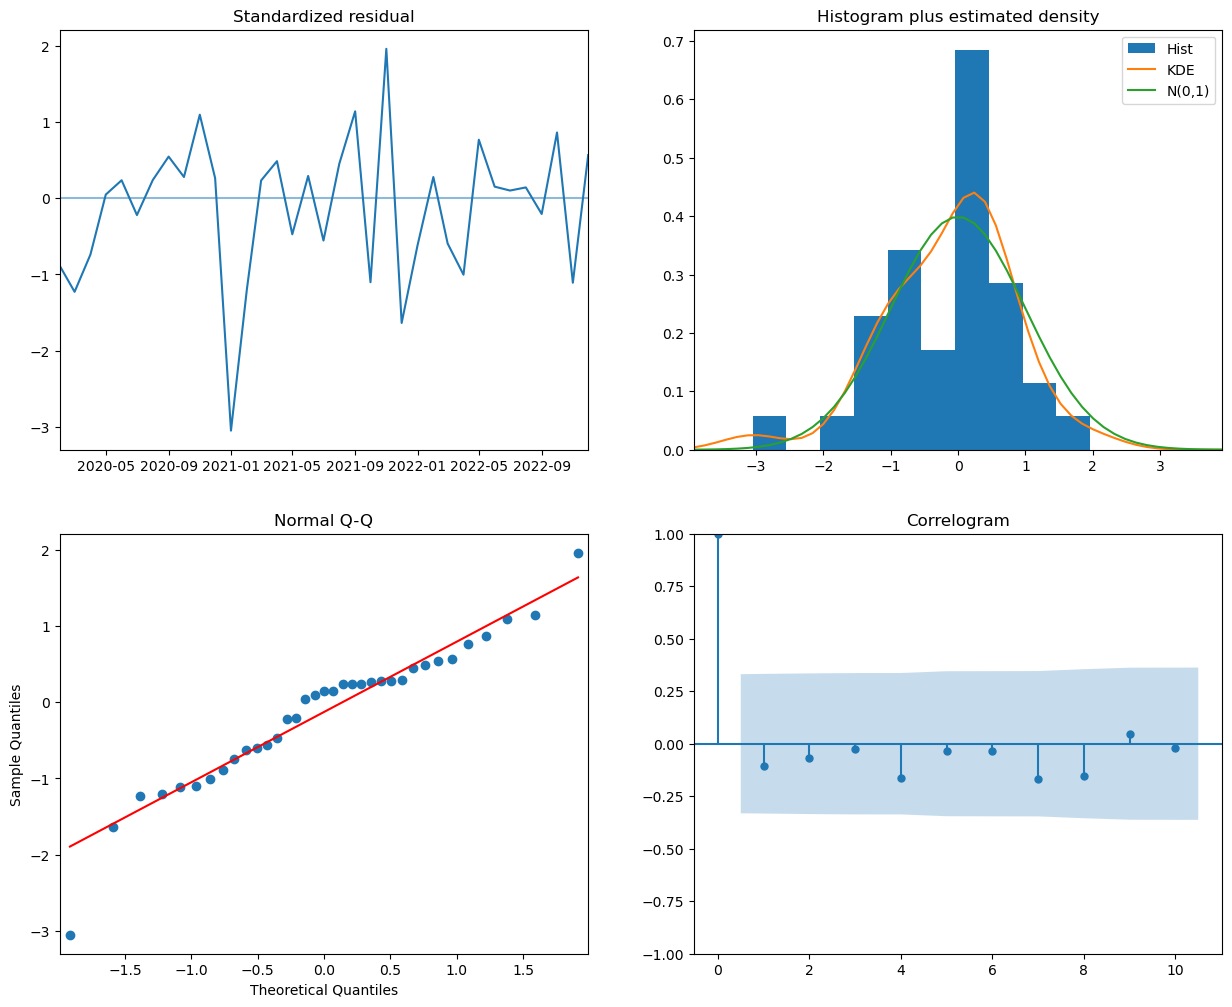

In [60]:
auto_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [61]:
forecast_test_auto= auto_arima.predict(n_periods=len(test), exogenous=test[['Market Size','Marketing Expense']])
sales_e['Forecast_AUTO ARIMA']=[None]*len(train)+ list(forecast_test_auto)
#sales_b[['Sales','Forecast_AUTO ARIMA']].plot()

Text(0.5, 1.0, 'Product E')

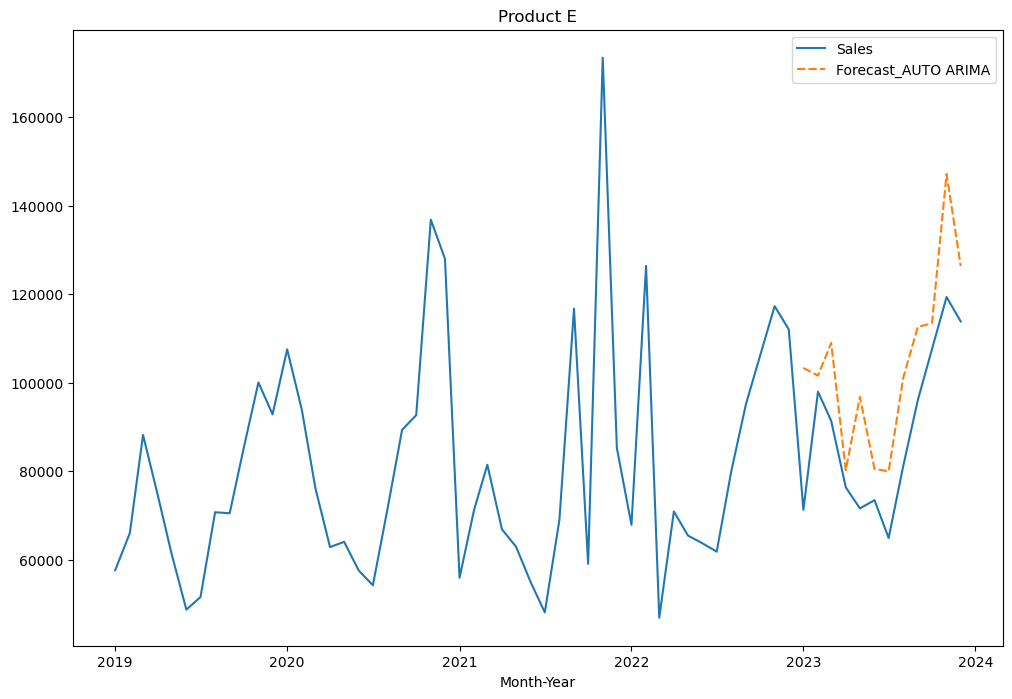

In [62]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_e[['Sales','Forecast_AUTO ARIMA']])
plt.title('Product E')

In [63]:
mae_auto_arimax= mean_absolute_error(test['Sales'],forecast_test_auto)
mape_auto_arimax= mean_absolute_percentage_error(test['Sales'],forecast_test_auto)
mse_auto_arimax=mean_squared_error(test['Sales'],forecast_test_auto)
rmse_auto_arimax= np.sqrt(mean_squared_error(test['Sales'],forecast_test_auto))

print(f'MAE - AUTO ARIMAX: {mae_auto_arimax}')
print(f'MAPE - AUTO ARIMAX: {mape_auto_arimax}')
print(f'MSE - AUTO ARIMAX: {mse_auto_arimax}')
print(f'RMSE - AUTO ARIMAX: {rmse_auto_arimax}')

MAE - AUTO ARIMAX: 15595.836350844278
MAPE - AUTO ARIMAX: 0.18545426856058547
MSE - AUTO ARIMAX: 326135255.8145881
RMSE - AUTO ARIMAX: 18059.215260209625


In [64]:
sales_e.tail(12)

,Sales,Market Size,Marketing Expense,Forecast_ARIMAX,Forecast_SARIMAX,Forecast_AUTO ARIMA
Month-Year,,,,,,
2023-01-01,71268,317822,1332763,73066.325753,76617.963188,103330.092702
2023-02-01,97965,436878,1832017,87955.520143,98871.610666,101611.906570
2023-03-01,91393,407570,1709115,84290.251991,86704.493566,108993.773767
2023-04-01,76364,340548,1428062,75908.453465,77383.019329,80214.005218
2023-05-01,71591,319262,1338804,73246.402773,73158.286192,96809.582304
2023-06-01,73457,327584,1373699,74287.167067,72176.203317,80530.781084
2023-07-01,64909,289464,1213845,69519.864054,66225.006939,79963.624440
2023-08-01,81175,362003,1518031,78591.629944,81972.848152,101103.765162
2023-09-01,96096,428543,1797065,86913.140209,98037.645126,112619.333977


In [65]:
sales_e.mean()

Sales                  8.209883e+04
Market Size            3.769448e+05
Marketing Expense      1.633066e+06
Forecast_ARIMAX        8.281754e+04
Forecast_SARIMAX       8.911603e+04
Forecast_AUTO ARIMA    1.043482e+05
dtype: float64

In [66]:
data = {
    'model': ['ARIMAX', 'AUTO ARIMAX', 'SEASONAL ARIMAX'],
    'MAE': [mae_arimax, mae_auto_arimax, mae_sarimax],  
    'MAPE': [mape_arimax, mape_auto_arimax, mape_sarimax],  
    'MSE': [mse_arimax, mse_auto_arimax, mse_sarimax],  
    'RMSE': [rmse_arimax, rmse_auto_arimax, rmse_sarimax]  
}

model_results = pd.DataFrame(data)
model_results.set_index('model', inplace=True)
model_results

,MAE,MAPE,MSE,RMSE
model,,,,
ARIMAX,7417.251927,0.073725,1.049455e+08,10244.292251
AUTO ARIMAX,15595.836351,0.185454,3.261353e+08,18059.215260
SEASONAL ARIMAX,5112.882877,0.051360,7.279017e+07,8531.715713


# TESTING

In [24]:
auto_arima_1= pm.auto_arima(train['Sales'], start_p=0, start_q=0, max_p=6,max_q=2,
                          start_P=0, start_Q=0, max_P=2 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12, exogenous=train[['Market Size','Marketing Expense']])
auto_arima_1

 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=840.073, Time=0.04 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=841.958, Time=0.11 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=842.613, Time=0.30 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=841.991, Time=0.09 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=842.832, Time=0.35 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=843.586, Time=1.58 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=842.694, Time=0.11 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=844.687, Time=0.24 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=844.454, Time=0.48 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=844.689, Time=0.19 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(0,0,1)(2,1,0)[12] inter

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True)

In [25]:
auto_arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   48
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -418.036
Date:                  Wed, 08 May 2024   AIC                            840.073
Time:                          19:27:28   BIC                            843.240
Sample:                      01-01-2019   HQIC                           841.178
                           - 12-01-2022                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4058.5000   4560.524      0.890      0.374   -4879.964     1.3e+04
sigma2       7.14e+08   1.81e+08      3.945      0.000    3.59e+08    1.07e+09
===================================================================================
Ljung-Box (L1) (Q):                   4.64   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.03   Prob(JB):                         0.76
Heteroskedasticity (H):               2.00   Skew:                            -0.29
Prob(H) (two-sided):                  0.25   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

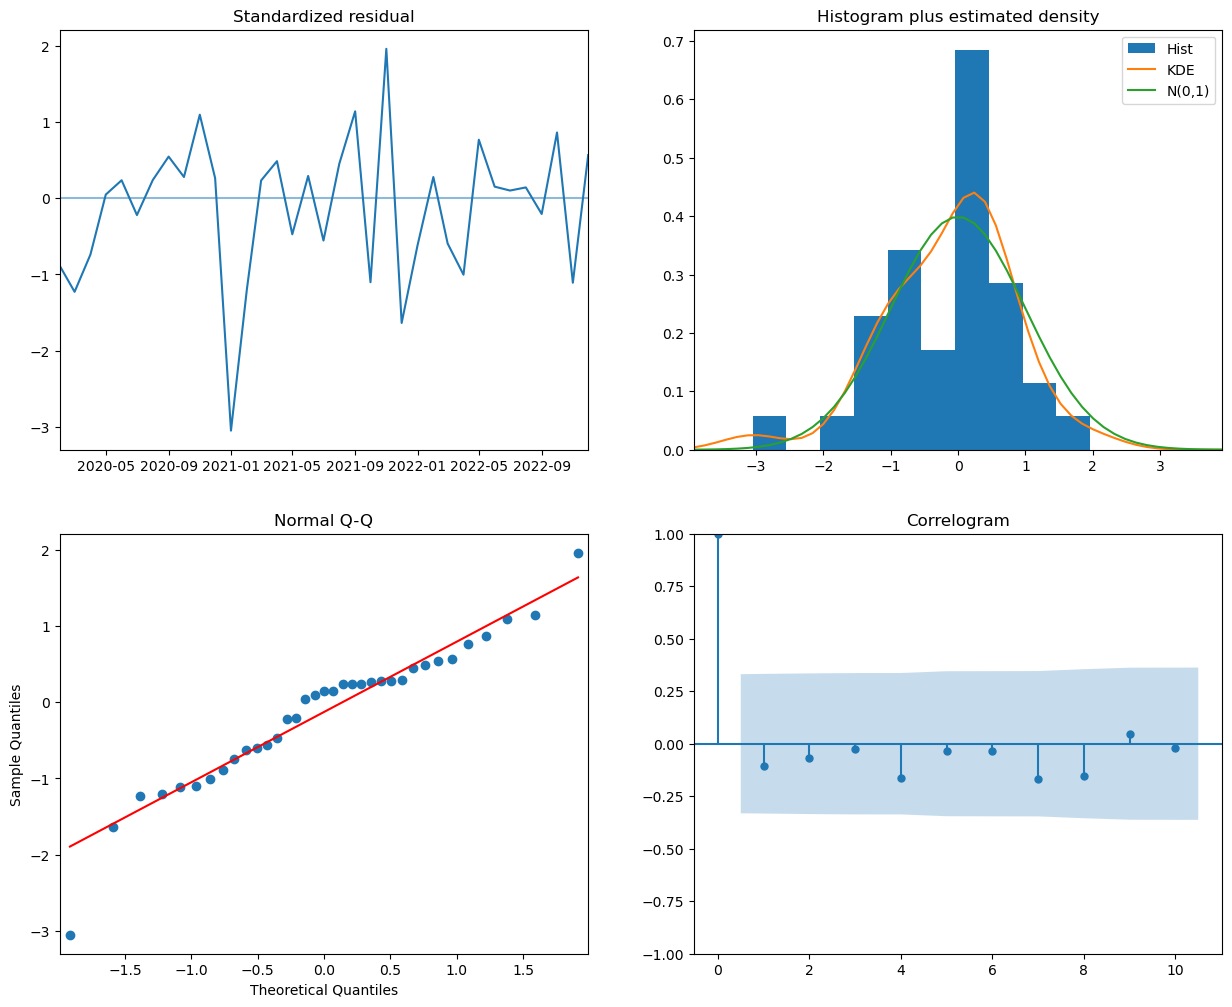

In [57]:
auto_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [58]:
forecast_test_auto_1= auto_arima_1.predict(n_periods=len(test), exogenous=test[['Market Size','Marketing Expense']])
sales_e['Forecast_AUTO ARIMA_1']=[None]*len(train)+ list(forecast_test_auto_1)

NameError: name 'auto_arima_1' is not defined

In [ ]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_e[['Sales','Forecast_AUTO ARIMA_1']])
plt.title('Product E')

In [59]:
mae_auto_arima_1= mean_absolute_error(test['Sales'],forecast_test_auto_1)
mape_auto_arima_1= mean_absolute_percentage_error(test['Sales'],forecast_test_auto_1)
mse_auto_arima_1=mean_squared_error(test['Sales'],forecast_test_auto_1)
rmse_auto_arima_1= np.sqrt(mean_squared_error(test['Sales'],forecast_test_auto_1))

print(f'MAE - AUTO ARIMA: {mae_auto_arima_1}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima_1}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima_1}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima_1}')

NameError: name 'forecast_test_auto_1' is not defined